In [2]:
import pandas as pd
import numpy as np
import tensorflow as tf
from tensorflow.keras.layers import Dense, Dropout, Flatten, GlobalAveragePooling2D, BatchNormalization, Conv2D, MaxPooling2D, RandomHeight, RandomWidth, RandomZoom, RandomRotation, RandomFlip
from tensorflow.keras import Model
from tensorflow.keras.models import Sequential
from keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.utils import array_to_img, img_to_array, load_img, image_dataset_from_directory
from tensorflow.keras.applications.mobilenet import preprocess_input

import matplotlib.pyplot as plt
import os
import imghdr

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import confusion_matrix, classification_report

from PIL import Image
from wordcloud import WordCloud


In [3]:
train = "../data/dog-breed-identification/train"
test = "../data/dog-breed-identification/test"
df=pd.read_csv("../data/dog-breed-identification/labels.csv")
df.describe()

,id,breed
count,10222,10222
unique,10222,120
top,000bec180eb18c7604dcecc8fe0dba07,scottish_deerhound
freq,1,126


In [4]:
df.head()

,id,breed
0,000bec180eb18c7604dcecc8fe0dba07,boston_bull
1,001513dfcb2ffafc82cccf4d8bbaba97,dingo
2,001cdf01b096e06d78e9e5112d419397,pekinese
3,00214f311d5d2247d5dfe4fe24b2303d,bluetick
4,0021f9ceb3235effd7fcde7f7538ed62,golden_retriever


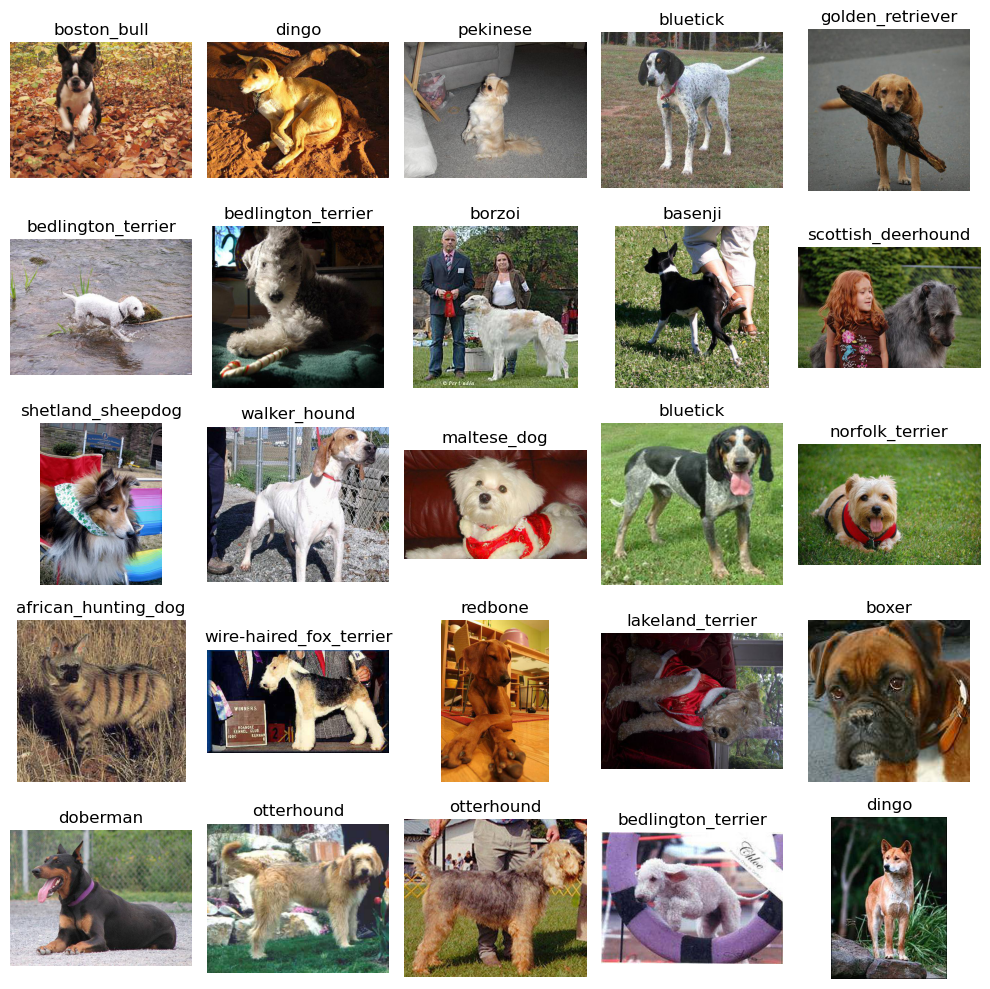

In [5]:
nrow = 5
ncol = 5
fig, ax = plt.subplots(nrow, ncol, figsize=(10, 10))

for i, (img_id, breed) in enumerate(df[["id", "breed"]].values[:nrow * ncol]):
    image_path = os.path.join(train, img_id + ".jpg")
    
    # Use PIL to open and convert the image
    image = Image.open(image_path)
    
    # Convert to RGB if the image is not already in RGB mode
    if image.mode != 'RGB':
        image = image.convert('RGB')
    
    row = i // ncol
    col = i % ncol
    
    ax[row, col].imshow(image)
    ax[row, col].set_title(breed)
    ax[row, col].axis("off")

plt.tight_layout()
plt.show()

In [6]:
print("Number of unique dog breeds: ", len(df.breed.unique()))

Number of unique dog breeds:  120


In [7]:
labels = df["breed"].unique().tolist()
print(labels)

['boston_bull', 'dingo', 'pekinese', 'bluetick', 'golden_retriever', 'bedlington_terrier', 'borzoi', 'basenji', 'scottish_deerhound', 'shetland_sheepdog', 'walker_hound', 'maltese_dog', 'norfolk_terrier', 'african_hunting_dog', 'wire-haired_fox_terrier', 'redbone', 'lakeland_terrier', 'boxer', 'doberman', 'otterhound', 'standard_schnauzer', 'irish_water_spaniel', 'black-and-tan_coonhound', 'cairn', 'affenpinscher', 'labrador_retriever', 'ibizan_hound', 'english_setter', 'weimaraner', 'giant_schnauzer', 'groenendael', 'dhole', 'toy_poodle', 'border_terrier', 'tibetan_terrier', 'norwegian_elkhound', 'shih-tzu', 'irish_terrier', 'kuvasz', 'german_shepherd', 'greater_swiss_mountain_dog', 'basset', 'australian_terrier', 'schipperke', 'rhodesian_ridgeback', 'irish_setter', 'appenzeller', 'bloodhound', 'samoyed', 'miniature_schnauzer', 'brittany_spaniel', 'kelpie', 'papillon', 'border_collie', 'entlebucher', 'collie', 'malamute', 'welsh_springer_spaniel', 'chihuahua', 'saluki', 'pug', 'malino

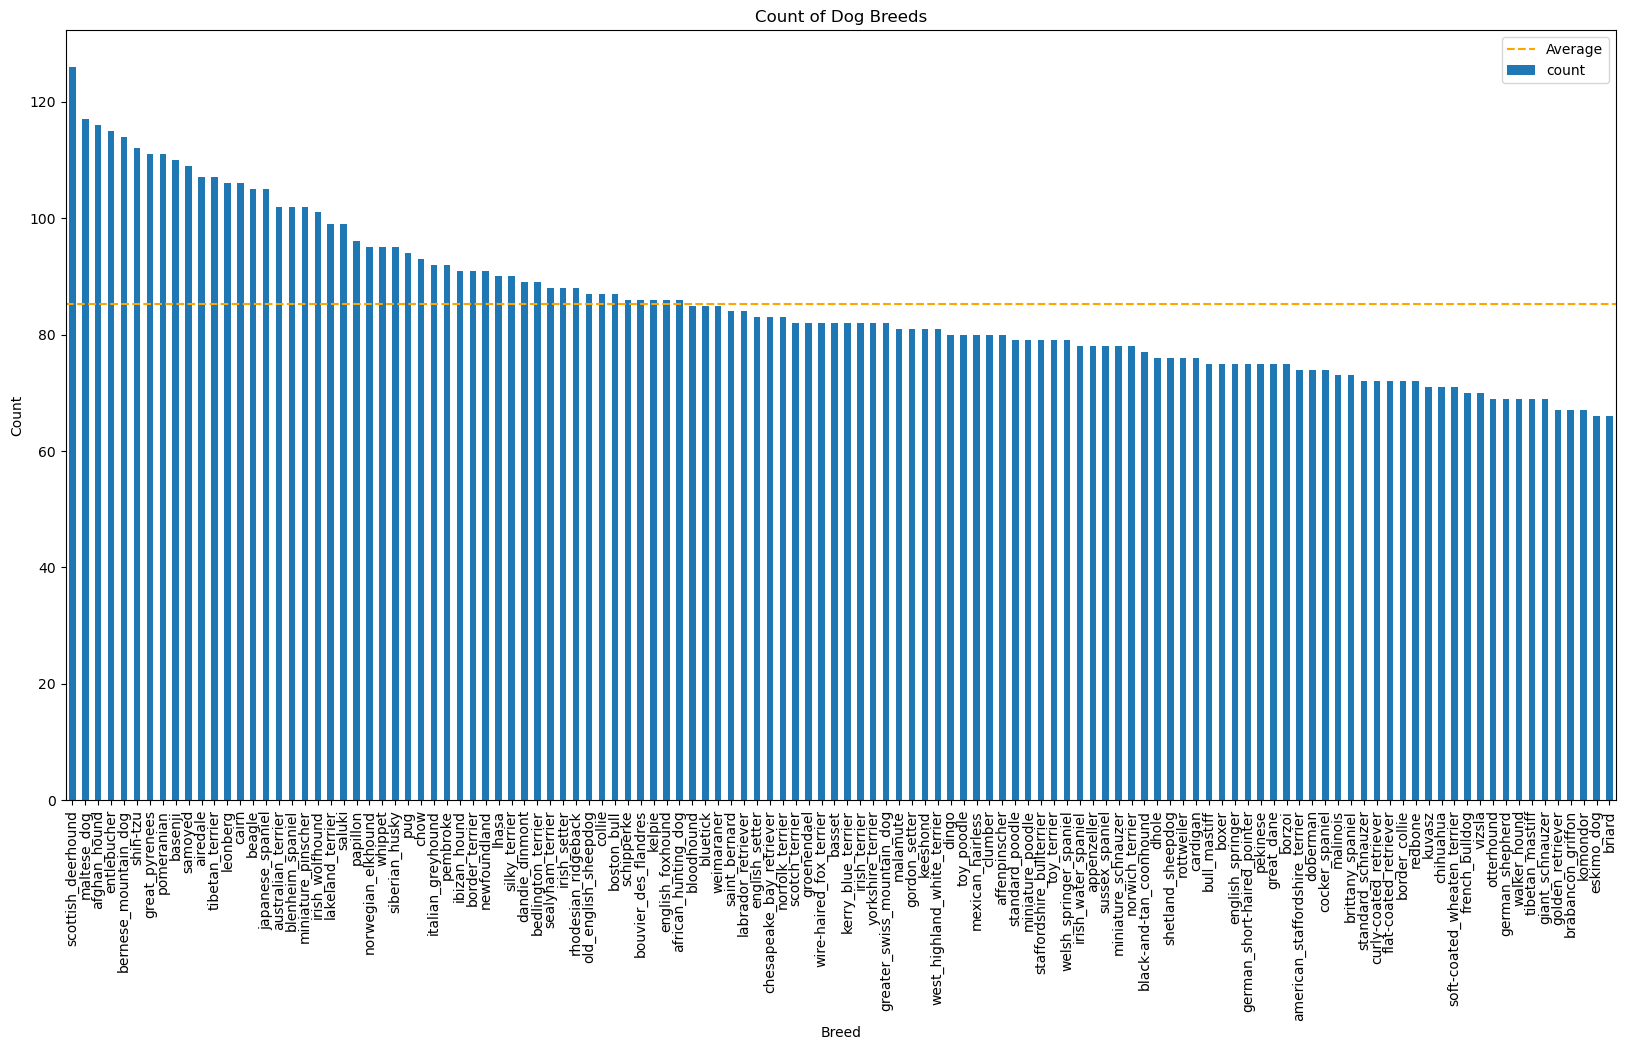

In [8]:
# Plot the bar chart of filname count per breed
ax = df["breed"].value_counts().plot.bar(figsize=(20, 10))

# calculate the average value
average_value = df["breed"].value_counts().mean()

# add the average line
ax.axhline(average_value, color='orange', linestyle='--', label='Average')

# Customize the plot as desired
plt.xlabel('Breed')
plt.ylabel('Count')
plt.title('Count of Dog Breeds')
plt.legend();

In [9]:
# add '.jpg' to id for image_id
df['image_file'] = df['id'].apply(lambda x: x + ".jpg")
df.head()

,id,breed,image_file
0,000bec180eb18c7604dcecc8fe0dba07,boston_bull,000bec180eb18c7604dcecc8fe0dba07.jpg
1,001513dfcb2ffafc82cccf4d8bbaba97,dingo,001513dfcb2ffafc82cccf4d8bbaba97.jpg
2,001cdf01b096e06d78e9e5112d419397,pekinese,001cdf01b096e06d78e9e5112d419397.jpg
3,00214f311d5d2247d5dfe4fe24b2303d,bluetick,00214f311d5d2247d5dfe4fe24b2303d.jpg
4,0021f9ceb3235effd7fcde7f7538ed62,golden_retriever,0021f9ceb3235effd7fcde7f7538ed62.jpg


In [16]:
# converting images to numpy array
image_size = 100  # Adjust to your desired image size

train_data = np.zeros((len(df), image_size, image_size, 3), dtype="float32")

for i, img_id in enumerate(df["image_file"]):
    img_path = os.path.join(train, img_id)
    img = Image.open(img_path)
    
    # Resize the image
    img = img.resize((image_size, image_size))
    
    # Convert to array and preprocess
    img_array = preprocess_input(np.expand_dims(np.array(img), axis=0))
    
    train_data[i] = img_array

In [17]:
train_data[i]

array([[[ 0.4666667 ,  0.4666667 ,  0.48235297],
        [ 0.43529415,  0.43529415,  0.45098042],
        [ 0.4666667 ,  0.4666667 ,  0.48235297],
        ...,
        [-0.16862744, -0.18431371, -0.17647058],
        [-0.32549018, -0.34117645, -0.3333333 ],
        [-0.32549018, -0.3333333 , -0.3333333 ]],

       [[ 0.4431373 ,  0.4431373 ,  0.45882356],
        [ 0.34901965,  0.34901965,  0.36470592],
        [ 0.32549024,  0.32549024,  0.3411765 ],
        ...,
        [-0.2862745 , -0.30196077, -0.29411763],
        [-0.2862745 , -0.30196077, -0.29411763],
        [-0.29411763, -0.30196077, -0.29411763]],

       [[ 0.3803922 ,  0.3803922 ,  0.39607847],
        [ 0.38823533,  0.38823533,  0.4039216 ],
        [ 0.26274514,  0.26274514,  0.27843142],
        ...,
        [-0.15294117, -0.16862744, -0.16862744],
        [-0.30196077, -0.31764704, -0.3098039 ],
        [ 0.03529418,  0.02745104,  0.05098045]],

       ...,

       [[ 0.62352943,  0.62352943,  0.62352943],
        [ 0

In [18]:
train_data.shape

(10222, 100, 100, 3)

In [19]:
num_breed = 120
image_size = 200
batch_size = 32
# instantiate LabelEncoder
encoder = LabelEncoder()

# fit & transform encoder on to label_data
label_data = encoder.fit_transform(df["breed"].values)

In [20]:
label_data.shape

(10222,)

In [21]:
X = train_data
y = label_data

# # split into training & validation sets
X_train, X_val, y_train, y_val = train_test_split(X,
                                                  y, 
                                                  test_size=0.2,
                                                  random_state=42)

len(X_train), len(y_train), len(X_val), len(y_val)

(8177, 8177, 2045, 2045)

In [30]:
# Create a Sequential model
base_model = Sequential()

# Add Convolutional layers
base_model.add(Conv2D(32, (3, 3), activation='relu', input_shape=(100, 100, 3)))
base_model.add(MaxPooling2D((2, 2)))

base_model.add(Conv2D(64, (3, 3), activation='relu'))
base_model.add(MaxPooling2D((2, 2)))

base_model.add(Conv2D(128, (3, 3), activation='relu'))
base_model.add(MaxPooling2D((2, 2)))

# Flatten the output and add Dense layers for classification
base_model.add(Flatten())
base_model.add(Dense(128, activation='relu'))
base_model.add(Dense(120, activation='softmax'))  # Assuming 10 output classes

# Compile the model
base_model.compile(optimizer='adam', loss='sparse_categorical_crossentropy', metrics=['accuracy'])

In [31]:
base_model.summary()

Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_6 (Conv2D)           (None, 98, 98, 32)        896       
                                                                 
 max_pooling2d_6 (MaxPoolin  (None, 49, 49, 32)        0         
 g2D)                                                            
                                                                 
 conv2d_7 (Conv2D)           (None, 47, 47, 64)        18496     
                                                                 
 max_pooling2d_7 (MaxPoolin  (None, 23, 23, 64)        0         
 g2D)                                                            
                                                                 
 conv2d_8 (Conv2D)           (None, 21, 21, 128)       73856     
                                                                 
 max_pooling2d_8 (MaxPoolin  (None, 10, 10, 128)      

In [32]:
first = base_model.fit(X_train, y_train, validation_data=(X_val, y_val), epochs=20, batch_size=64)

Epoch 1/20
128/128 [==============================] - 31s 236ms/step - loss: 4.7598 - accuracy: 0.0125 - val_loss: 4.6445 - val_accuracy: 0.0342
Epoch 2/20
128/128 [==============================] - 31s 242ms/step - loss: 4.4932 - accuracy: 0.0368 - val_loss: 4.4422 - val_accuracy: 0.0362
Epoch 3/20
128/128 [==============================] - 31s 244ms/step - loss: 4.2315 - accuracy: 0.0667 - val_loss: 4.3569 - val_accuracy: 0.0469
Epoch 4/20
128/128 [==============================] - 31s 243ms/step - loss: 3.9619 - accuracy: 0.1042 - val_loss: 4.3755 - val_accuracy: 0.0557
Epoch 5/20
128/128 [==============================] - 31s 243ms/step - loss: 3.5791 - accuracy: 0.1636 - val_loss: 4.4431 - val_accuracy: 0.0557
Epoch 6/20
128/128 [==============================] - 31s 242ms/step - loss: 3.0292 - accuracy: 0.2639 - val_loss: 4.9749 - val_accuracy: 0.0567
Epoch 7/20
128/128 [==============================] - 31s 243ms/step - loss: 2.3436 - accuracy: 0.4074 - val_loss: 5.9243 - val_ac

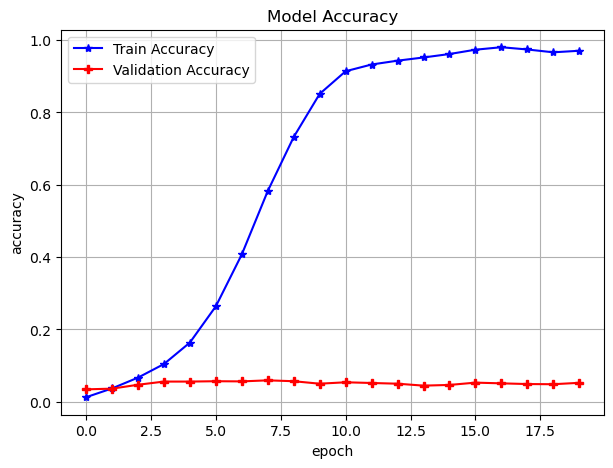

In [33]:
# graph of accuracy of training & validation data
plt.figure(figsize=(7,5))
plt.plot(first.history['accuracy'],label="Train Accuracy",color="blue",marker="*")
plt.plot(first.history['val_accuracy'],label="Validation Accuracy",color="red",marker="P")
plt.grid(True)
plt.legend()
plt.title('Model Accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.show()

In [37]:
# Preprocessing test images like the training set
# List all image files in the testing data path
test_image_files = os.listdir(test)

# Specify the image size
image_size = 100  # Adjust to your desired image size

# Preprocess testing data
test_data = np.zeros((len(test_image_files), image_size, image_size, 3), dtype="float32")

for i, img_id in enumerate(test_image_files):
    img_path = os.path.join(test, img_id)
    img = Image.open(img_path)
    
    # Resize the image
    img = img.resize((image_size, image_size))
    
    # Convert to array and preprocess
    img_array = preprocess_input(np.expand_dims(np.array(img), axis=0))
    
    test_data[i] = img_array

In [38]:
# Make predictions on the testing data
predictions = base_model.predict(test_data)

324/324 [==============================] - 12s 37ms/step


In [40]:
# Evaluate the model on the testing data
evaluation_results = base_model.evaluate(test_data)

# Extract the loss score
loss_score = evaluation_results[0]

# Print the loss score
print(f'Test Loss: {loss_score:.4f}')

324/324 [==============================] - 0s 1ms/step - loss: 0.0000e+00 - accuracy: 0.0000e+00
Test Loss: 0.0000


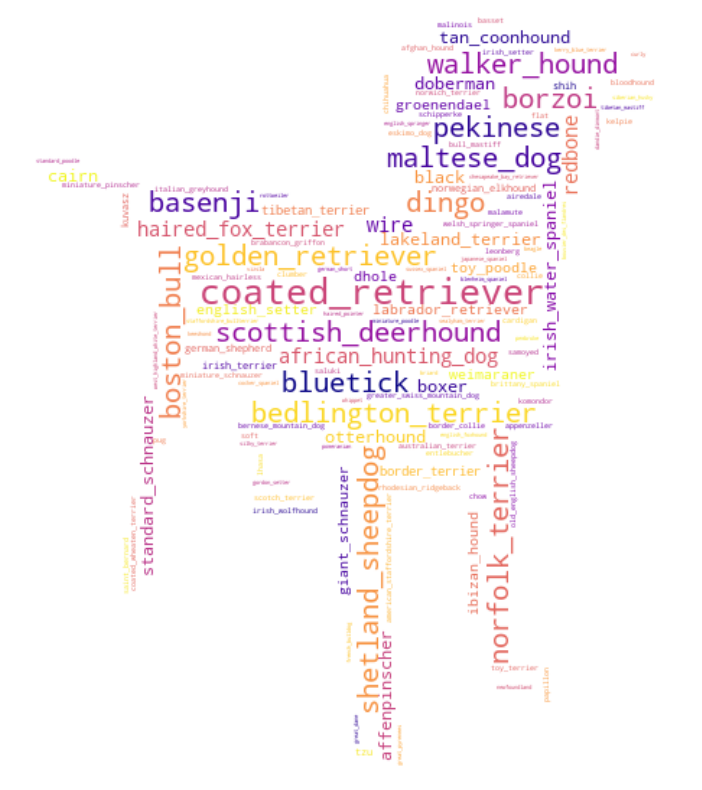

In [54]:
# word cloud of breeds for fun
# join breed names into a single string
text = ' '.join(labels)

mask = np.array(Image.open("../data/dog-silhouette.jpg"))

wordcloud = WordCloud(width=600, height=300, 
                      colormap="plasma", 
                      mask=mask, 
                      background_color='white'
                      ).generate(text)
plt.figure(figsize=(10, 10))
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis('off')
plt.show()